In [1]:
from srn import HandPose
from srn.config import config
import numpy as np
import pickle
from tqdm import tqdm
from dataclasses import dataclass
from scipy.signal import medfilt
from scipy.ndimage import interpolation as inter
from ddnet import Predictor
import random

In [2]:
@dataclass
class Config:
    num_frames = 30
    num_points = 21
    dim_point = 3
    dim_jcd = 210
    num_classes = 14
    num_filters = 64
    dir_data = './data/'
    
C = Config()

In [3]:
# labels = [
#     "Grab(1)",
#     "Grab(2)",
#     "Tap(1)",
#     "Tap(2)",
#     "Expand(1)",
#     "Expand(2)",
#     "Pinch(1)",
#     "Pinch(2)",
#     "Rotate Clockwise(1)",
#     "Rotate Clockwise(2)",
#     "Rotate Counter Clockwise(1)",
#     "Rotate Counter Clockwise(2)",
#     "Swipe Right(1)",
#     "Swipe Right(2)",
#     "Swipe Left(1)",
#     "Swipe Left(2)",
#     "Swipe Up(1)",
#     "Swipe Up(2)",
#     "Swipe Down(1)",
#     "Swipe Down(2)",
#     "Swipe X(1)",
#     "Swipe X(2)",
#     "Swipe +(1)",
#     "Swipe +(2)",
#     "Swipe V(1)",
#     "Swipe V(2)",
#     "Shake(1)",
#     "Shake(2)",
# ]

labels = [
    "Grab",
    "Tap",
    "Expand",
    "Pinch",
    "Rotate Clockwise",
    "Rotate Counter Clockwise",
    "Swipe Right",
    "Swipe Left",
    "Swipe Up",
    "Swipe Down",
    "Swipe X",
    "Swipe +",
    "Swipe V",
    "Shake",
]

In [4]:
def zoom(p, C: Config, target_l=30):
    """ Resize framerate to desired length """
    l = p.shape[0]
    p_new = np.empty([target_l, C.num_points, C.dim_point]) 
    for m in range(C.num_points):
        for n in range(C.dim_point):
            p[:, m, n] = medfilt(p[:, m, n], 3)
            p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]
    return p_new

In [5]:
test = pickle.load(open('./notebooks/data/test.pkl', 'rb'))

In [6]:
_KEY_X = 'pose'
_KEY_Y = 'coarse_label'
# 'fine_label' == 28 gestures
# 'coarse_label' == 14 gestures
X_test = list()
Y_test = list()

for ds, X, Y in [(test, X_test, Y_test),]:
    for idx in tqdm(range(len(ds[_KEY_X]))):
        p = ds[_KEY_X][idx]
        p = np.reshape(p, (-1, 21, 3))
        p = zoom(p, C)
        
        l = np.zeros(C.num_classes)
        l[ds[_KEY_Y][idx] - 1] = 1
        
        X.append(p)
        Y.append(l)

X_test = np.stack(X_test)
Y_test = np.stack(Y_test)

Y_test.shape

100%|██████████| 840/840 [00:06<00:00, 130.55it/s]


(840, 14)

In [7]:
Y_test[839]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [8]:
def zoom(p: np.array, target_l=30):
    """ Resize framerate to desired length """
    l = p.shape[0]
    p_new = np.empty([target_l, 21, 3])
    for m in range(21):
        for n in range(3):
            p[:, m, n] = medfilt(p[:, m, n], 3)
            p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]
    return p_new

def sampling_frame(p: list):
    """ I don't know what this does """
    p = np.array(p)
    p = np.reshape(p, (-1, 21, 3))
    full_l = p.shape[0]  # full length
    if random.uniform(0, 1) < 0.5:  # aligment sampling
        valid_l = np.round(np.random.uniform(0.9, 1) * full_l)
        s = random.randint(0, full_l - int(valid_l))
        e = s + valid_l  # sample end point
        p = p[int(s) : int(e), :, :]
    else:  # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9, 1) * full_l)
        index = np.sort(np.random.choice(range(0, full_l), int(valid_l), replace=False))
        p = p[index, :, :]
    p = zoom(p)
    return p

def normalize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

In [2]:
pose_predictor = HandPose(config)
gesture_recognizer = Predictor()

## Prediction Pipeline

In [10]:
root_dir = '/media/dexter/7786037C0F8CEE68/BE_Research/DHG/'
test_list = np.loadtxt( root_dir + 'test_gestures.txt').astype('int16')

# Y_pred = list()
pose_pred = list()

for i in tqdm(range(len(test_list))):
    idx_gesture = test_list[i][0]
    idx_finger = test_list[i][1]
    idx_subject = test_list[i][2]
    idx_essai = test_list[i][3]
    coarse_label = test_list[i][4]
    fine_label = test_list[i][5]
    number_of_frames = test_list[i][6]
    skeleton_path = root_dir + 'gesture_' + str(idx_gesture) + '/finger_' \
                + str(idx_finger) + '/subject_' + str(idx_subject) + '/essai_' + str(idx_essai)+'/'
    
    
    poses = pose_predictor.run(skeleton_path)
    filename = skeleton_path + 'predicted_world_bn_25.txt'
    file = open(filename, 'w')
    
    if poses.shape[0] == number_of_frames:
        for idx in range(poses.shape[0]):
            np.savetxt(file, poses[idx].reshape(1, -1), fmt='%.3f')
    else:
        break

 11%|█         | 90/840 [07:15<31:22,  2.51s/it]  /home/dexter/anaconda3/envs/anton/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dexter/anaconda3/envs/anton/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dexter/anaconda3/envs/anton/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
 23%|██▎       | 195/840 [13:01<43:20,  4.03s/it] /home/dexter/anaconda3/envs/anton/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dexter/anaconda3/envs/anton/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dexter/anaconda3/envs/anton/lib/

## Prediction from prediction_skeleton_world.txt

In [43]:
root_dir = '/media/dexter/7786037C0F8CEE68/BE_Research/DHG/'
test_list = np.loadtxt( root_dir + 'test_gestures.txt').astype('int16')
# sav_dir = '/media/dexter/7786037C0F8CEE68/BE_Research/HandGestureDataset_SHREC2017/'

Y_pred = list()
pose_pred = list()

for i in tqdm(range(len(test_list))):
    idx_gesture = test_list[i][0]
    idx_finger = test_list[i][1]
    idx_subject = test_list[i][2]
    idx_essai = test_list[i][3]
    coarse_label = test_list[i][4]
    fine_label = test_list[i][5]
    number_of_frames = test_list[i][6]
    
    skeleton_path = root_dir + 'gesture_' + str(idx_gesture) + '/finger_' \
                + str(idx_finger) + '/subject_' + str(idx_subject) + '/essai_' + str(idx_essai)+'/'
    
#     poses = np.loadtxt(skeleton_path + 'predicted_skeleton_world.txt').astype('float32')
    poses = np.loadtxt(skeleton_path + 'predicted_world_0_00094.txt').astype('float32')
    poses = poses.reshape(number_of_frames, 21, 3)
    
    model_input = normalize_range(poses)
    model_input = sampling_frame(model_input)
    label = gesture_recognizer.predict(model_input)
    Y_pred.append(label)

100%|██████████| 840/840 [00:43<00:00, 19.18it/s]


## Saving prediction_skeleton_world.txt

In [44]:
Y_true = []
for i in np.argmax(Y_test,axis=1):
    Y_true.append(labels[i])

In [45]:
from sklearn import metrics
print(" Accuracy ---> ({0:.4f})".format(metrics.accuracy_score(Y_true, Y_pred)))

 Accuracy ---> (0.8750)


In [14]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")


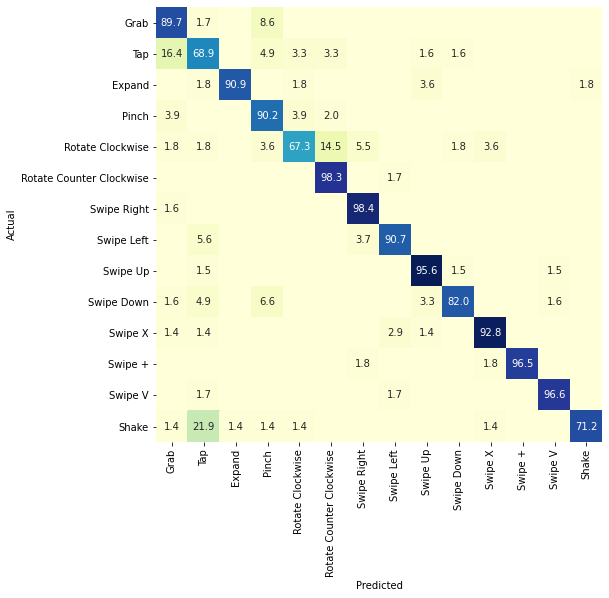

In [15]:
cm_analysis(Y_true, Y_pred, labels, ymap=None, figsize=(8,8))